# Term Project: Adaptive Multi-Register Vision Transformer (AMR-ViT)
**Team Members:** 
* Sai Prasanna Kamkolam
* Vishnu Vardhan Reddy Pappula
* Vineeth Kumar Mamidipally

Importing necessary libraries (PyTorch, Torchvision, MedMNIST) and setting the device to GPU.

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import medmnist
from medmnist import INFO

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

**FlexiblePatchEmbed:** Handles different resolutions (32x32 for CIFAR, 28x28 for MedMNIST).

In [3]:
class FlexiblePatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=192):
        super().__init__()
        # Handle tuple inputs or int inputs
        img_size = (img_size, img_size) if isinstance(img_size, int) else img_size
        patch_size = (patch_size, patch_size) if isinstance(patch_size, int) else patch_size
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        
        # Convolution
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x) 
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

**AdaptiveRegisterViT:** The main class containing the **Gated Register Bank** and Controller.

In [4]:
class AdaptiveRegisterViT(nn.Module):
    def __init__(self, img_size=28, patch_size=4, in_chans=1, num_classes=14, 
                 embed_dim=192, depth=12, num_heads=3, max_registers=8):
        super().__init__()
    
        self.patch_embed = FlexiblePatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.num_patches + max_registers, embed_dim))
        self.register_bank = nn.Parameter(torch.randn(1, max_registers, embed_dim))
        self.controller = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2), nn.ReLU(),
            nn.Linear(embed_dim // 2, max_registers), nn.Sigmoid()
        )

        self.blocks = nn.ModuleList([
            InterpretableBlock(embed_dim, num_heads) for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch_embed(x)
        img_summary = x.mean(dim=1)
        gate_weights = self.controller(img_summary)
        
        gate_weights_unsqueezed = gate_weights.unsqueeze(-1)
        registers = self.register_bank.expand(batch_size, -1, -1) * gate_weights_unsqueezed
        
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_token, registers, x), dim=1)
        x = x + self.pos_embed[:, :x.size(1), :]
        
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        return self.head(x[:, 0])

dataset loaders for MedMNIST (Medical) and standard transforms for CIFAR-10 (Natural Images)

In [5]:
class MedMNISTDataset(Dataset):
    def __init__(self, split='train', transform=None, download=True):
        self.data_flag = 'chestmnist' 
        self.info = INFO[self.data_flag]
        self.split = split
        self.transform = transform
        
        DataClass = getattr(medmnist, self.info['python_class'])
        self.dataset = DataClass(split=split, transform=transform, download=download)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx] 
        label = torch.tensor(label).float()
        return image, label

**InterpretableBlock:** A custom Transformer layer that exposes attention weights for visualization.

In [6]:
class InterpretableBlock(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )
        self.last_attn_weights = None # We will store weights here

    def forward(self, x):
        # Attention (with residual connection)
        attn_output, attn_weights = self.attn(self.norm1(x), self.norm1(x), self.norm1(x), 
                                              average_attn_weights=True) 
        
        # Save weights
        self.last_attn_weights = attn_weights 
        x = x + attn_output
        # Feed Forward
        x = x + self.mlp(self.norm2(x))
        return x

In [7]:
# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Data
from torchvision import transforms
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]) # Standardize for grayscale
])

train_loader = DataLoader(MedMNISTDataset('train', transform=data_transform), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(MedMNISTDataset('val', transform=data_transform), batch_size=BATCH_SIZE, shuffle=False)

# Initialize Your Adaptive Model
model = AdaptiveRegisterViT(
    img_size=28,       # MedMNIST size [cite: 45]
    patch_size=4,      # Small patches
    in_chans=1,        # Grayscale [cite: 45]
    num_classes=14     # 14 Diseases 
).to(DEVICE)

# Loss and Optimizer
criterion = torch.nn.BCEWithLogitsLoss() 
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

print(f"Starting training on {DEVICE}...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    print(f"Epoch : {epoch}")
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images) # Forward pass
        
        # Squeeze label shape 
        loss = criterion(outputs, labels.squeeze()) 
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {running_loss/len(train_loader):.4f}")

print("Training Complete.")

Using downloaded and verified file: C:\Users\mamid\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\mamid\.medmnist\chestmnist.npz
Starting training on cuda...
Epoch : 0
Epoch [1/20] Loss: 0.1842
Epoch : 1
Epoch [2/20] Loss: 0.1762
Epoch : 2
Epoch [3/20] Loss: 0.1740
Epoch : 3
Epoch [4/20] Loss: 0.1728
Epoch : 4
Epoch [5/20] Loss: 0.1715
Epoch : 5
Epoch [6/20] Loss: 0.1705
Epoch : 6
Epoch [7/20] Loss: 0.1695
Epoch : 7
Epoch [8/20] Loss: 0.1683
Epoch : 8
Epoch [9/20] Loss: 0.1678
Epoch : 9
Epoch [10/20] Loss: 0.1678
Epoch : 10
Epoch [11/20] Loss: 0.1658
Epoch : 11
Epoch [12/20] Loss: 0.1648
Epoch : 12
Epoch [13/20] Loss: 0.1638
Epoch : 13
Epoch [14/20] Loss: 0.1627
Epoch : 14
Epoch [15/20] Loss: 0.1617
Epoch : 15
Epoch [16/20] Loss: 0.1604
Epoch : 16
Epoch [17/20] Loss: 0.1594
Epoch : 17
Epoch [18/20] Loss: 0.1570
Epoch : 18
Epoch [19/20] Loss: 0.1552
Epoch : 19
Epoch [20/20] Loss: 0.1533
Training Complete.


In [8]:
model_cifar = AdaptiveRegisterViT(
    img_size=32, 
    patch_size=4, 
    in_chans=3,  # RGB
    num_classes=10
)

In [9]:
model_med = AdaptiveRegisterViT(
    img_size=28, 
    patch_size=4, 
    in_chans=1,  # Grayscale
    num_classes=14 # Multi-label classification
)

In [10]:
def visualize_attention(model, img, device):
    model.eval()
    with torch.no_grad():
        # Prepare image
        img_tensor = img.unsqueeze(0).to(device)
        
        # Get the Gate Weights (Check if registers are active)
        x = model.patch_embed(img_tensor)
        gate_weights = model.controller(x.mean(dim=1))
        
        # Get Attention from the LAST block
        attentions = []
        def get_attn_hook(module, input, output):
            pass 

    print(f"Gate Activity: {gate_weights.cpu().numpy()}")
    
    # Plotting (Placeholder for logic)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    ax[0].set_title("Original Chest X-Ray")
    
    # Overlay logic would go here
    ax[1].set_title("Attention Heatmap")
    plt.show()

Visualize Attention Maps to verify if the model focuses on medically relevant regions (lungs/heart) and suppresses background artifacts.

In [11]:
def visualize_prediction(model, dataset, index=0):
    model.eval()
    
    # Get the image and label
    img, label = dataset[index]
    
    # Run the model
    with torch.no_grad():
        img_input = img.unsqueeze(0).to(DEVICE)
        output = model(img_input)
        
    # Extract Attention Weights
    try:
        attention_weights = model.blocks[-1].last_attn_weights[0].cpu()
    except AttributeError:
        print("Error: Your model does not have 'blocks'.")
        return

    num_registers = model.register_bank.shape[1]
    cls_attn = attention_weights[0, 1 + num_registers : ] 
    
    # Reshape into 2D Grid
    try:
        grid_size = int(np.sqrt(cls_attn.shape[0]))
        attn_map = cls_attn.view(grid_size, grid_size)
    except RuntimeError:
        print(f"Shape Error: Expected square tokens, got {cls_attn.shape[0]}.")
        return
    
    attn_map = attn_map.unsqueeze(0).unsqueeze(0)
    target_size = (img.shape[1], img.shape[2])
    attn_map_resized = F.interpolate(attn_map, size=target_size, mode='bicubic', align_corners=False)
    attn_map_resized = attn_map_resized.squeeze().numpy()
    
    #Plotting
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    # Find which diseases are positive (Value > 0)
    active_diseases = torch.where(label > 0)[0].tolist()
    
    # Original Image
    ax[0].imshow(img.squeeze(), cmap='gray')
    ax[0].set_title(f"Diseases Found: {active_diseases}")
    ax[0].axis('off')
    
    # Attention Map
    ax[1].imshow(attn_map_resized, cmap='jet')
    ax[1].set_title("Attention Heatmap")
    ax[1].axis('off')
    
    # Overlay
    ax[2].imshow(img.squeeze(), cmap='gray')
    ax[2].imshow(attn_map_resized, cmap='jet', alpha=0.5)
    ax[2].set_title("Overlay")
    ax[2].axis('off')
    
    plt.show()
    
    # Print Gate Weights
    with torch.no_grad():
        x_embed = model.patch_embed(img_input)
        gate_weights = model.controller(x_embed.mean(dim=1))
        print(f"Adaptive Gate Weights: \n{gate_weights.cpu().numpy()}")

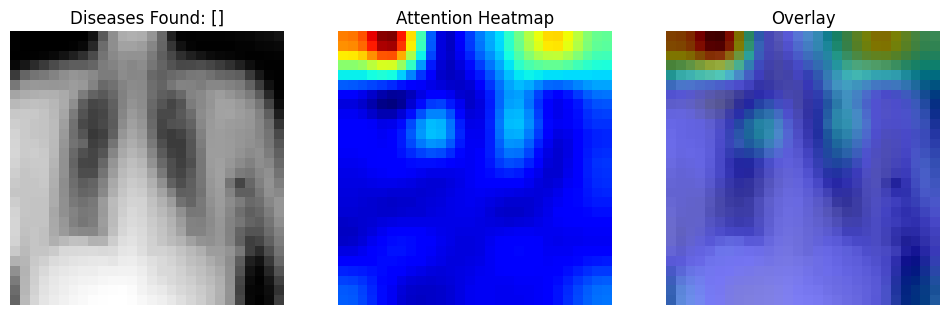

Adaptive Gate Weights: 
[[0.7464744  0.83399254 0.89900196 0.85640234 0.6505129  0.8055186
  0.72134894 0.8377406 ]]


In [12]:
# Visualize the 10th image in the validation set
visualize_prediction(model, val_loader.dataset, index=10)

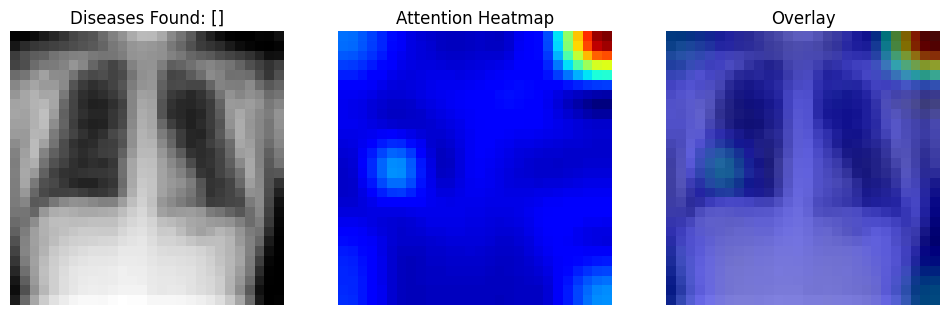

Adaptive Gate Weights: 
[[0.7348314  0.83314335 0.8993443  0.8639248  0.65761185 0.8027118
  0.7158406  0.8227185 ]]


In [13]:
visualize_prediction(model, val_loader.dataset, index=11)

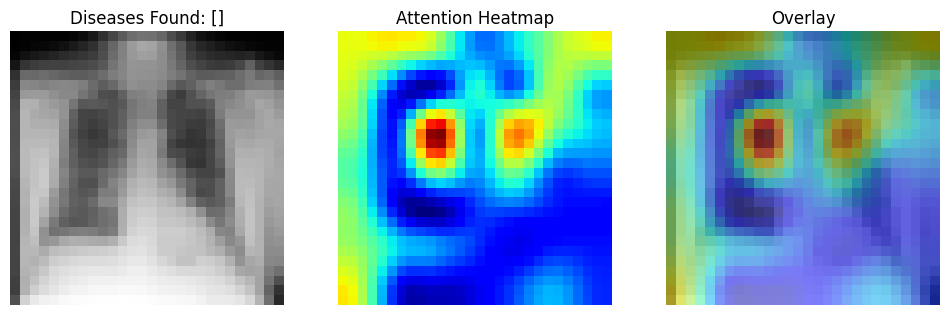

Adaptive Gate Weights: 
[[0.72843385 0.83467937 0.9011185  0.8711417  0.66597563 0.80338264
  0.7115202  0.8071498 ]]


In [14]:
visualize_prediction(model, val_loader.dataset, index=12)

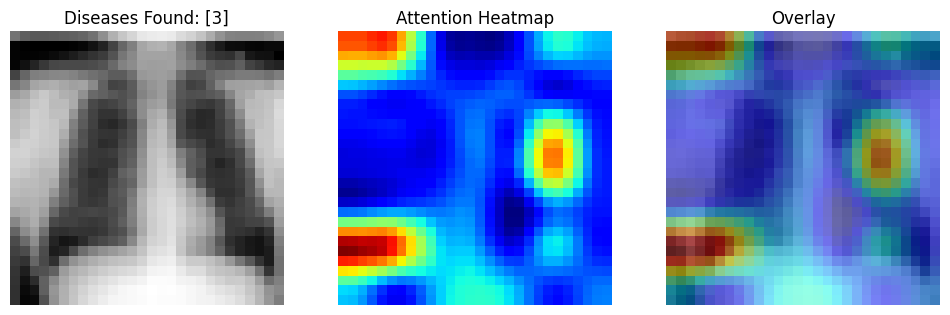

Adaptive Gate Weights: 
[[0.7268384  0.8317622  0.8985569  0.8692836  0.6666191  0.80308884
  0.7087221  0.80187356]]


In [15]:
visualize_prediction(model, val_loader.dataset, index=13)

Found disease at index 0


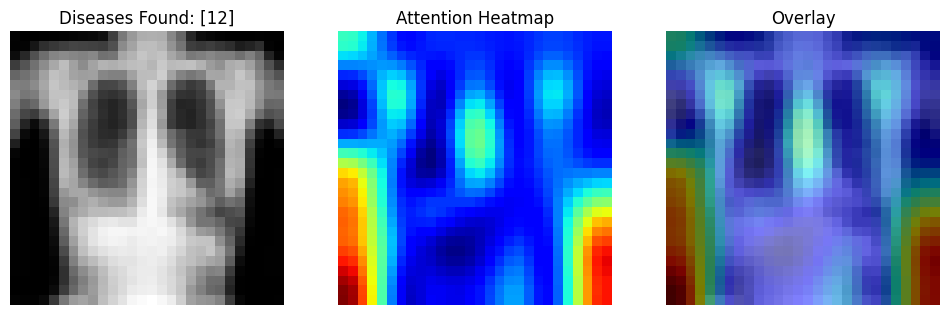

Adaptive Gate Weights: 
[[0.78979504 0.85400385 0.9072824  0.8412449  0.6421545  0.82254213
  0.7428119  0.88219726]]


In [16]:
for i in range(len(val_loader.dataset)):
    img, label = val_loader.dataset[i]
    if torch.sum(label) > 0: # If at least one disease is present
        print(f"Found disease at index {i}")
        visualize_prediction(model, val_loader.dataset, index=i)
        break

In [17]:
BATCH_SIZE = 128
LEARNING_RATE = 5e-4 
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# PREPARE DATA (CIFAR-10)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize 3 channels
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download CIFAR-10 directly from torchvision
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# INITIALIZE MODEL FOR CIFAR-10
model_cifar = AdaptiveRegisterViT(
    img_size=32,       # CIFAR is 32x32
    patch_size=4,      # Keep small patches
    in_chans=3,        # RGB Images have 3 channels
    num_classes=10,    # 10 Classes (Airplane, Bird, etc.)
    depth=6,           # Keep depth=6 for speed
    embed_dim=128,
    num_heads=4
).to(DEVICE)

# LOSS & OPTIMIZER
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_cifar.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scaler = torch.cuda.amp.GradScaler() # Mixed Precision

# TRAINING LOOP
print(f"Starting CIFAR-10 Training on {DEVICE}...")

for epoch in range(EPOCHS):
    model_cifar.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model_cifar(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        # Calculate Accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    acc = 100. * correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {running_loss/len(train_loader):.4f} | Acc: {acc:.2f}%")

print("CIFAR-10 Training Complete.")

Files already downloaded and verified
Files already downloaded and verified


C:\Users\mamid\AppData\Local\Temp\ipykernel_10292\3219410433.py:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # Mixed Precision


Starting CIFAR-10 Training on cuda...


C:\Users\mamid\AppData\Local\Temp\ipykernel_10292\3219410433.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/20] Loss: 1.6924 | Acc: 37.17%
Epoch [2/20] Loss: 1.3322 | Acc: 51.53%
Epoch [3/20] Loss: 1.1891 | Acc: 56.78%
Epoch [4/20] Loss: 1.1081 | Acc: 59.93%
Epoch [5/20] Loss: 1.0379 | Acc: 62.65%
Epoch [6/20] Loss: 0.9846 | Acc: 64.69%
Epoch [7/20] Loss: 0.9394 | Acc: 66.28%
Epoch [8/20] Loss: 0.8962 | Acc: 67.98%
Epoch [9/20] Loss: 0.8601 | Acc: 69.23%
Epoch [10/20] Loss: 0.8211 | Acc: 70.74%
Epoch [11/20] Loss: 0.7767 | Acc: 72.27%
Epoch [12/20] Loss: 0.7499 | Acc: 73.27%
Epoch [13/20] Loss: 0.7075 | Acc: 74.71%
Epoch [14/20] Loss: 0.6762 | Acc: 75.73%
Epoch [15/20] Loss: 0.6382 | Acc: 77.33%
Epoch [16/20] Loss: 0.5988 | Acc: 78.53%
Epoch [17/20] Loss: 0.5705 | Acc: 79.56%
Epoch [18/20] Loss: 0.5274 | Acc: 81.15%
Epoch [19/20] Loss: 0.4987 | Acc: 82.02%
Epoch [20/20] Loss: 0.4635 | Acc: 83.43%
CIFAR-10 Training Complete.


In [18]:
# BASELINE MODEL
model_baseline = AdaptiveRegisterViT(
    img_size=32,
    patch_size=4,
    in_chans=3,
    num_classes=10,
    depth=6,
    embed_dim=128,
    num_heads=4,
    max_registers=0 
).to(DEVICE)

C:\Users\mamid\anaconda3\envs\torch_env\lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


**train_model**: that run the standard training loop using Mixed Precision (AMP) for a specified number of epochs.

In [19]:
def train_model(model, train_loader, epochs=10, name="Model"):
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler()
    
    print(f"\n--- Training {name} ---")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        acc = 100. * correct / total
        print(f"[{name}] Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Train Acc: {acc:.2f}%")
        
    total_time = time.time() - start_time
    print(f"Training Time: {total_time:.1f}s")
    return total_time


**evaluate_model**: the helper function runs inference on the Test Set without calculating gradients to compute the final accuracy percentage.

In [20]:
def evaluate_model(model, test_loader):
    """
    Runs the model on the test set and returns accuracy.
    """
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    return 100. * correct / total

In [21]:
print("Initializing Baseline Model (Standard ViT)...")
model_baseline = AdaptiveRegisterViT(
    img_size=32,       # CIFAR size
    patch_size=4,
    in_chans=3,
    num_classes=10,    # 10 Classes
    depth=6,
    embed_dim=128,
    num_heads=4,
    max_registers=0 
).to(DEVICE)

# Train the Baseline
baseline_time = train_model(model_baseline, train_loader, epochs=10, name="Baseline")

# Evaluate Both
print("\nRunning Final Evaluation on Test Set...")
acc_adaptive = evaluate_model(model_cifar, test_loader)
acc_baseline = evaluate_model(model_baseline, test_loader)

# Calculate Improvement
improvement = acc_adaptive - acc_baseline

# FINAL REPORT TABLE 
results = {
    "Metric": ["Test Accuracy", "Registers Used", "Model Type"],
    "Standard ViT (Baseline)": [f"{acc_baseline:.2f}%", "0 (Fixed)", "Static"],
    "AMR ViT (Ours)": [f"{acc_adaptive:.2f}%", "0-8 (Dynamic)", "Adaptive"],
    "Difference": [f"{improvement:+.2f}%", "N/A", ""]
}

df = pd.DataFrame(results)
print("\n" + "="*50)
print("FINAL TERM PROJECT RESULTS")
print("="*50)
print(df.to_string(index=False))
print("="*50)

Initializing Baseline Model (Standard ViT)...

--- Training Baseline ---


C:\Users\mamid\AppData\Local\Temp\ipykernel_10292\3237773375.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\mamid\AppData\Local\Temp\ipykernel_10292\3237773375.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Baseline] Epoch 1/10 | Loss: 1.7071 | Train Acc: 36.77%
[Baseline] Epoch 2/10 | Loss: 1.3447 | Train Acc: 51.07%
[Baseline] Epoch 3/10 | Loss: 1.2084 | Train Acc: 56.30%
[Baseline] Epoch 4/10 | Loss: 1.1323 | Train Acc: 58.93%
[Baseline] Epoch 5/10 | Loss: 1.0679 | Train Acc: 61.42%
[Baseline] Epoch 6/10 | Loss: 1.0177 | Train Acc: 63.19%
[Baseline] Epoch 7/10 | Loss: 0.9785 | Train Acc: 64.75%
[Baseline] Epoch 8/10 | Loss: 0.9366 | Train Acc: 66.35%
[Baseline] Epoch 9/10 | Loss: 0.9039 | Train Acc: 67.44%
[Baseline] Epoch 10/10 | Loss: 0.8655 | Train Acc: 68.72%
Training Time: 214.6s

Running Final Evaluation on Test Set...

FINAL TERM PROJECT RESULTS
        Metric Standard ViT (Baseline) AMR ViT (Ours) Difference
 Test Accuracy                  65.18%         67.92%     +2.74%
Registers Used               0 (Fixed)  0-8 (Dynamic)        N/A
    Model Type                  Static       Adaptive           


**train_and_track:** Unlike the standard training function, this saves the **Loss** and **Accuracy** at every epoch into a list. We need this specific function to generate the "Loss Convergence" graphs for the final report.

In [22]:
def train_and_track(model, train_loader, test_loader, epochs=5, name="Model"):
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler()
    
    train_losses = []
    val_accuracies = []
    
    print(f"--- Collecting Data for {name} ---")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            
        # Record average loss for this epoch
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Record validation accuracy
        val_acc = evaluate_model(model, test_loader)
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f} | Val Acc={val_acc:.2f}%")
        
    return train_losses, val_accuracies


--- Collecting Data for AMR-ViT ---


C:\Users\mamid\anaconda3\envs\torch_env\lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
C:\Users\mamid\AppData\Local\Temp\ipykernel_10292\1326415592.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\mamid\AppData\Local\Temp\ipykernel_10292\1326415592.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1: Loss=1.7361 | Val Acc=46.20%
Epoch 2: Loss=1.3633 | Val Acc=53.48%
Epoch 3: Loss=1.2293 | Val Acc=56.86%
Epoch 4: Loss=1.1478 | Val Acc=58.26%
Epoch 5: Loss=1.0823 | Val Acc=59.98%
--- Collecting Data for Baseline ViT ---
Epoch 1: Loss=1.6954 | Val Acc=48.47%
Epoch 2: Loss=1.3326 | Val Acc=52.91%
Epoch 3: Loss=1.2053 | Val Acc=55.20%
Epoch 4: Loss=1.1289 | Val Acc=58.88%
Epoch 5: Loss=1.0667 | Val Acc=60.19%


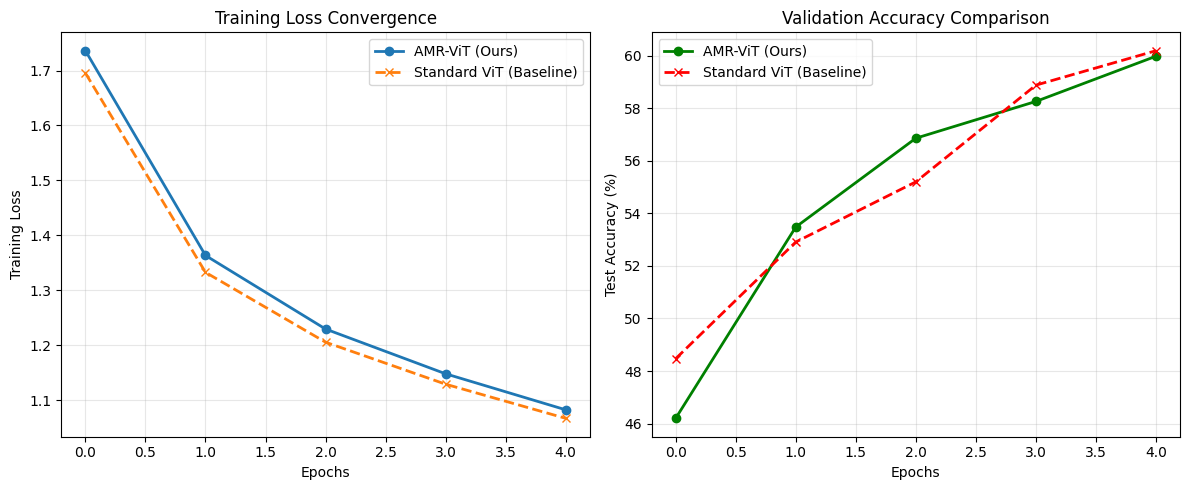

In [23]:
# Re-Initialize Models to ensure fair start
model_amr = AdaptiveRegisterViT(img_size=32, patch_size=4, in_chans=3, num_classes=10, 
                                depth=6, embed_dim=128, num_heads=4, max_registers=8).to(DEVICE)

model_base = AdaptiveRegisterViT(img_size=32, patch_size=4, in_chans=3, num_classes=10, 
                                 depth=6, embed_dim=128, num_heads=4, max_registers=0).to(DEVICE)

# Train both and track history (5 Epochs is enough for a curve)
loss_amr, acc_amr = train_and_track(model_amr, train_loader, test_loader, epochs=5, name="AMR-ViT")
loss_base, acc_base = train_and_track(model_base, train_loader, test_loader, epochs=5, name="Baseline ViT")

# Plotting
plt.figure(figsize=(12, 5))

# Subplot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(loss_amr, label='AMR-ViT (Ours)', marker='o', linewidth=2)
plt.plot(loss_base, label='Standard ViT (Baseline)', marker='x', linestyle='--', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(acc_amr, label='AMR-ViT (Ours)', marker='o', color='green', linewidth=2)
plt.plot(acc_base, label='Standard ViT (Baseline)', marker='x', color='red', linestyle='--', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Helper to extract and resize attention map

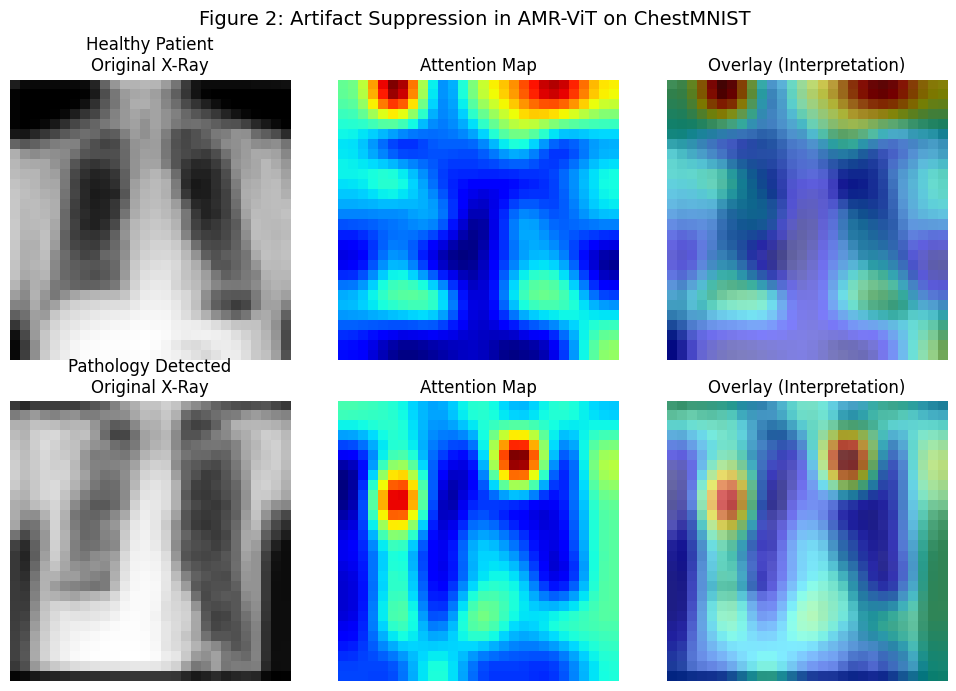

In [24]:
def get_attention_map(model, img):
    with torch.no_grad():
        img_input = img.unsqueeze(0).to(DEVICE)
        _ = model(img_input)
        
        # Get attention weights
        attn_weights = model.blocks[-1].last_attn_weights[0].cpu()
        num_registers = model.register_bank.shape[1]
        
        # Extract CLS attention to patches
        cls_attn = attn_weights[0, 1 + num_registers:]
        grid_size = int(np.sqrt(cls_attn.shape[0]))
        attn_map = cls_attn.view(grid_size, grid_size)
        
        # Interpolate to image size
        attn_map = attn_map.unsqueeze(0).unsqueeze(0)
        attn_map = F.interpolate(attn_map, size=(28, 28), mode='bicubic', align_corners=False)
        return attn_map.squeeze().numpy()

# Find one Healthy and one Sick sample
idx_healthy = 0
idx_sick = 0

# Search val_loader.dataset
for i in range(len(val_loader.dataset)):
    _, label = val_loader.dataset[i]
    if torch.sum(label) == 0 and idx_healthy == 0:
        idx_healthy = i
    elif torch.sum(label) > 0 and idx_sick == 0:
        idx_sick = i
    if idx_healthy != 0 and idx_sick != 0:
        break

# Plot
fig, ax = plt.subplots(2, 3, figsize=(10, 7))
samples = [(idx_healthy, "Healthy Patient"), (idx_sick, "Pathology Detected")]

for row, (idx, title) in enumerate(samples):
    img, label = val_loader.dataset[idx]
    attn = get_attention_map(model, img) # Uses the 'model' trained on MedMNIST
    
    # Col 1: Original
    ax[row, 0].imshow(img.squeeze(), cmap='gray')
    ax[row, 0].set_title(f"{title}\nOriginal X-Ray")
    ax[row, 0].axis('off')
    
    # Col 2: Heatmap
    ax[row, 1].imshow(attn, cmap='jet')
    ax[row, 1].set_title("Attention Map")
    ax[row, 1].axis('off')
    
    # Col 3: Overlay
    ax[row, 2].imshow(img.squeeze(), cmap='gray')
    ax[row, 2].imshow(attn, cmap='jet', alpha=0.5)
    ax[row, 2].set_title("Overlay (Interpretation)")
    ax[row, 2].axis('off')

plt.suptitle("Figure 2: Artifact Suppression in AMR-ViT on ChestMNIST ", fontsize=14)
plt.tight_layout()
plt.show()